## NOTES

Author: Alberto Ciacci

E-mail: alberto.ciacci16@imperial.ac.uk

Language: python

Comments, corrections and suggestions are very much welcome.

## SUMMARY

This notebook implements a neural network model to predict whether a news is fake or real.

The input dataset is available at https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset.

The code allows the user to choose whether to implement a "personalized" embedding layer or to use the pretrained Glove-Twitter.
Furthermore, the code lets the user choose the number of LSTM and dense layers that follow the first embeddings layer. 

In this experiment, our model achieves very satisfactory accuracy levels, i.e., > 99%, in predicting previously unseen news.



## REFERENCES

1. Some segments of this notebook are inspired by the contents of Chapter 6 of "Deep Learning with Python", Francois Chollet, Manning.
2. Some segments of this notebook are inspired by the wonderful notebook available here https://www.kaggle.com/madz2000/nlp-using-glove-embeddings-99-87-accuracy (Credits to the author).

## IMPORT LIBRARIES

We begin by importing the libraries needed to perform the incoming tasks.

In [ ]:
import os
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models, layers, regularizers, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.util import ngrams
import nltk
import collections
from sklearn.metrics import confusion_matrix
import seaborn as sns
import bs4 as bs4 
import re
import string
import unicodedata
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

## DEFINE AUXILIARY FUNCTIONS

The following cells supplies auxiliary functions that can be used to achieve the objectives of the present script

1. clean_text -> takes a sentence as an input and perform different tasks in order to remove certain characters and punctuations.
2. create_wordcloud -> produces a word cloud, that is, a way to visualize the most relevant words within the input dataset.
3. create_corpus -> takes the text and creates a list containing every word appearing in the dataset.
3. preprocess_embeddings -> loads the pretrained word embeddings Glove and returns an embedding matrix that is used to set the weights of the embeddings layer in the neural network.
4. build_model_nlp_lstm -> returns a Keras model object of an artificial neural network for natural language processing, i.e., include an embedding layer, which might also include one or more LSTM structures and regular dense layers.
5. analyze_performances -> plots the trajectories of two different performance metrics (i.e., loss and accuracy) recorded at the end of each epoch for both the training and the testing phases.
6. model_evaluation -> evaluates the ability of the trained model to predict the labels of previously unseen samples (test set) and visualize the result into a confusion matrix.        

In [ ]:
def clean_text(sentence):
    
    # Taken and amended from this notebook https://www.kaggle.com/madz2000/nlp-using-glove-embeddings-99-87-accuracy
    # Full credits to the author
    
    tmp_sentence = bs4.BeautifulSoup(sentence,"html.parser")
    sentence = tmp_sentence.get_text()
    sentence = re.sub('\[[^]]*\]', '', sentence)
    sentence = re.sub(r'http\S+', '', sentence)
    
    stop_words = set(stopwords.words('english'))
    puncts = list(string.punctuation)
    stop_words.update(puncts)
    
    temp = []
    for j in sentence.split():
        if j.strip().lower() not in stop_words:
            temp.append(j.strip())
    sentence = " ".join(temp)
    return sentence

def create_wordcloud(text):
    
    wordcloud = WordCloud(max_font_size=30, max_words=200, background_color="white",colormap = 'cool',stopwords = set(STOPWORDS)).generate(text)
    plt.figure(figsize=(15,15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def create_corpus(input_text):

    # Taken and amended from this notebook https://www.kaggle.com/madz2000/nlp-using-glove-embeddings-99-87-accuracy
    # Full credits to the author
    
    list_of_words = []
    for single_text in input_text:
        for word in single_text.split():
            list_of_words.append(word.strip())
    return list_of_words

def preprocess_embeddings(embeddings_path, max_words, embedding_dim, word_index):
    
    # Strongly inspired by listings 6.10 and 6.11 of "Deep Learning with Python", Francois Chollet, Manning.
    
    embeddings_idx = {};
    embeddings_file = open(embeddings_path)
    for row in embeddings_file:
        split_row = row.split()
        word = split_row[0]
        values = np.asarray(split_row[1:],dtype='float32')
        embeddings_idx[word] = values
    embeddings_file.close()
    print(str(len(embeddings_idx)) + " words detected.")
    
    embeddings_mat = np.zeros((max_words, embedding_dim))
    
    for word, idx in word_index.items():
        if (idx < max_words):
            embedding_vector = embeddings_idx.get(word)
            if embedding_vector is not None:
                embeddings_mat[idx] = embedding_vector
    
    return embeddings_mat

def build_model_nlp_lstm(regression_problem, max_words, embedding_dim, max_len, pre_trained_embeddings, embeddings_matrix, lstm_bidirectional, lstm_layers_neurons, lstm_layers_recurrent_dropout, lstm_layers_dropout, hidden_layers_neurons, hidden_activation_function, L1_coeffs, L2_coeffs, hidden_layers_dropout, final_layer_neurons, final_activation_function, model_optimizer, loss_function, metrics):
    
    model = models.Sequential()
    model.add(layers.Embedding(max_words,embedding_dim,input_length = max_len))
    if (pre_trained_embeddings == True):
         model.layers[0].set_weights([embeddings_matrix])
         model.layers[0].trainable = False
        
    for i in range(len(lstm_layers_neurons)):
        
         if ((i == 0) & (len(lstm_layers_neurons) > 1)):
             return_sequences_bool = True
         else:
             return_sequences_bool = False
            
         if (lstm_bidirectional == True):
             model.add(layers.Bidirectional(layers.LSTM(lstm_layers_neurons[i],
                                                        return_sequences = return_sequences_bool, 
                                                        recurrent_dropout = lstm_layers_recurrent_dropout[i], 
                                                        dropout = lstm_layers_dropout[i])))            
         else:
             model.add(layers.LSTM(lstm_layers_neurons[i],
                                   return_sequences = return_sequences_bool, 
                                   recurrent_dropout = lstm_layers_recurrent_dropout[i], 
                                   dropout = lstm_layers_dropout[i]))
    
    for i in range(len(hidden_activation_function)):
               
        model.add(layers.Dense(hidden_layers_neurons[i], 
                               kernel_regularizer = regularizers.l1_l2(l1 = L1_coeffs[i], l2 =  L2_coeffs[i]),  
                               activation=hidden_activation_function[i]))
        if (hidden_layers_dropout[i] > 0.0):
            model.add(layers.Dropout(hidden_layers_dropout[i]))
            
    if regression_problem:
            model.add(layers.Dense(final_layer_neurons))
    else:
            model.add(layers.Dense(final_layer_neurons,
                                   activation = final_activation_function))
            
    model.compile(optimizer = model_optimizer, loss = loss_function, metrics = metrics)
    
    return model


def analyze_performances(hst, epochs):
    
    history_dict             = hst.history
    loss_values              = history_dict['loss']
    validation_loss_values   = history_dict['val_loss']
    acc_values               = history_dict['accuracy']
    validation_acc_values    = history_dict['val_accuracy']
    epochs                   = range(1,len(loss_values) + 1)
    fig, axes                = plt.subplots(1,2,figsize = (20,10))
    training_ts              = [loss_values, acc_values]
    validation_ts            = [validation_loss_values, validation_acc_values]
    metric_names             = ['loss', 'accuracy']
    for i in range(len(axes)):
        axes[i].plot(epochs,training_ts[i],color = 'r',label = 'training')
        axes[i].plot(epochs,validation_ts[i],color = 'b',label = 'validation')
        axes[i].set_xlabel('epoch')
        axes[i].set_ylabel(metric_names[i])
        axes[i].set_title(metric_names[i] + ' analysis')
        axes[i].set_xticks(np.arange(0,epochs[-1] + 1,5))
        axes[i].set_yticks(np.arange(0,1.1,0.1))
        axes[i].set_xlim([1,epochs[-1]])
        axes[i].set_ylim([0,1])
        axes[i].legend()
    plt.show()


def model_evaluation(model, x_test, y_test):
    
    predictions = model.predict_classes(x_test)
    matrix      = confusion_matrix(y_test,predictions.flatten())
    rel_matrix  = matrix/np.sum(matrix,axis = 0)
    fig, axes   = plt.subplots(1,2,figsize = (20,40))
    class_labels= np.unique(y_test)

    image1 = axes[0].imshow(matrix, cmap=plt.get_cmap('GnBu'))
    for (i, j), e in np.ndenumerate(matrix):
        axes[0].text(j, i, s = str(e), ha='center', va='center')
    axes[0].set_xticks(np.arange(0,len(class_labels), 1))
    axes[0].set_xticklabels(class_labels)
    axes[0].set_yticks(np.arange(0,len(class_labels), 1))
    axes[0].set_yticklabels(class_labels)
    axes[0].set_title('Confusion Matrix')
    
    image2 = axes[1].imshow(matrix/np.sum(matrix,axis = 0), cmap=plt.get_cmap('GnBu'))
    for (i, j), e in np.ndenumerate(rel_matrix):
        axes[1].text(j, i, s = str(np.round(e,2)), ha='center', va='center')
    axes[1].set_xticks(np.arange(0,len(class_labels), 1))
    axes[1].set_xticklabels(class_labels)
    axes[1].set_yticks(np.arange(0,len(class_labels), 1))
    axes[1].set_yticklabels(class_labels)
    plt.subplots_adjust(wspace = 0.5)
    axes[1].set_title('Confusion Matrix (Relative)')                      
    plt.show()

## INPUT DASHBOARD

We let the user set several variables that affect the estimation of the model:

* fake_path -> specify the path of the dataset including pieces of news that have been labelled as fake.
* true_path -> specify the path of the dataset including pieces of news that have been labelled as true.
* test_split    -> fraction of samples that will be excluded from any training process and used as previously unseen inputs that the model will attempt to classify during the test phase.
* regression_problem  -> indicates whether we are facing a regression problem. If = True, the final layer of the densely connected neural network won't have any specified activation function.  
* max_words -> The maximum number of words to be considered in the tokenizer.
* embedding_dim -> The dimension of the space in which the input words are "converted" into vectors. If pre_trained_embeddings = True, the admissible values are 25, 50, 100 and 200.
* max_len -> The maximum length (in number of words) of the sentences.
* pre_trained_embeddings -> Indicates whether the weights of the embedding layers should be loaded from Glove. If = True, the embedding layer will use weights from glove. 
* pre_trained_embeddings_path -> specify the path of the pre-trained embeddings.
* lstm_bidirectional -> Indicates whether the LSTM layers is bidirectional. If = True, the sequence goes in both direction.
* lstm_layers_neurons -> list containing the number of neurons forming each layer of the LSTM that follows the embeddings layer.
* lstm_layers_recurrent_dropout -> list containing the fractions of weights that are randomly set to zero in each layer of the LSTM that follows the embeddings layer. Set it to 0 to avoid dropout regularization.
* lstm_layers_dropout -> list containing the fractions of weights that are randomly set to zero in each layer of the LSTM that follows the embeddings layer. Set it to 0 to avoid dropout regularization.
* hidden_activation_function -> list containing the name of the activation functions (available in Keras) used in the hidden layers of the densely connected neural network that follows the LSTM.
* hidden_layers_neurons -> list containing the number of neurons forming each hidden layer of the densely connected neural network that follows the LSTM.
* hidden_layers_L1_coeffs -> list containing scalars multiplying the L1-penalty terms for each hidden layer weights of the densely connected neural network that follows the LSTM. Set it to 0 to avoid L1-regularization.
* hidden_layers_L2_coeffs -> list containing scalars multiplying the L2-penalty terms for each hidden layer weights of the densely connected neural network that follows the LSTM. Set it to 0 to avoid L2-regularization.
* hidden_layers_dropouts ->  list containing the fractions of weights that are randomly set to zero in each hidden layer of the densely connected neural network that follows the sequence of convolutions. Set it to 0 to avoid dropout regularization.
* final_activation_function -> name of the activation function (available in Keras) used in the terminal layer of the densely connected neural network that follows the LSTM.
* final_layer_neurons -> number of neurons forming the terminal layer of the densely connected neural network that follows the LSTM.
* model_optimizer -> name of the method (available in Keras) to iteratively update the search of the set of parameters that minimize the loss function.
* loss_function -> name the loss function (available in Keras) that we seek to minimize.
* metrics -> list containing the name of the metrics (available in Keras) that we use to assess the performances of the model.
* n_epochs -> the times the optimization algorithm goes through the entire training data set.
* batch_size -> the number of samples included in a single batch.

In [ ]:
fake_path                      =  "/kaggle/input/fake-and-real-news-dataset/Fake.csv"
true_path                      =  "/kaggle/input/fake-and-real-news-dataset/True.csv"
test_split                     = 0.2
regression_problem             = False
max_words                      = 20000
embedding_dim                  = 50
max_len                        = 250
pre_trained_embeddings         = True
pre_trained_embeddings_path    =  "/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B." + str(embedding_dim) + "d.txt"
lstm_bidirectional             = True
lstm_layers_neurons            = [64,32]
lstm_layers_recurrent_dropout  = [0.20,0.1]
lstm_layers_dropout            = [0.20,0.1]
hidden_activation_function     = ['relu']
hidden_layers_neurons          = [64]
hidden_layers_L1_coeffs        = [0.00]
hidden_layers_L2_coeffs        = [0.00]
hidden_layers_dropout          = [0.00]
final_activation_function      = 'sigmoid'
final_layer_neurons            = 1
model_optimizer                = optimizers.RMSprop(lr=1e-4)
loss_function                  = 'binary_crossentropy'
metrics                        = ['accuracy']
n_epochs                       = 25
batch_size                     = 275

## COMBINE FAKE AND REAL NEWS DATASETS 

We combine the two pandas dataframes.

In [ ]:
df_fake = pd.read_csv(fake_path)
df_fake['label'] = 'false'
df_true = pd.read_csv(true_path)
df_true['label'] = 'true'
df_full = pd.concat([df_fake, df_true], ignore_index=True)
labels = df_full['label']

## CLEAN THE SENTENCES

We use a dedicated function to remove stopwords, punctuation and other characters from the sentence column.

See the function "clean_text" at the top of this notebook for details. 

I give credits to the author of this notebook https://www.kaggle.com/madz2000/nlp-using-glove-embeddings-99-87-accuracy for inspirations on how to clean text.

In [ ]:
df_full['text']=df_full['text'].apply(clean_text)

## CREATE A WORDCLOUD FOR FAKE NEWS

We use the wordcloud library to display "clouds" of the most relevant words in the "fake" news class.

See the function "create_wordcloud" at the top of this notebook for details.


In [ ]:
create_wordcloud(" ".join(text for text in df_full.loc[df_full['label'] == 'false','text']))

## CREATE A WORDCLOUD FOR TRUE NEWS

We use the wordcloud library to display "clouds" of the most relevant words in the "true" news class.

See the function "create_wordcloud" at the top of this notebook for details.

In [ ]:
create_wordcloud(" ".join(text for text in df_full.loc[df_full['label'] == 'true','text']))

## DATASET DESCRIPTIVE ANALYSIS

We display simple histograms in order to examine the frequency of each label (false vs. true) in the entire dataset (left) and within each topic (right).


In [ ]:
fig, axes = plt.subplots(2,2,figsize=(30,30))
sns.countplot(x= 'label', data = df_full, palette='magma', ax = axes[0,0])
axes[0,0].set_xlabel('News label')
axes[0,0].set_ylabel('# Samples')
axes[0,0].set_title('Absolute frequency false vs. true news')

sns.countplot(y= 'subject', hue = 'label', data = df_full, palette='magma', ax = axes[0,1])
axes[0,1].set_xlabel('News topic')
axes[0,1].set_ylabel('# Samples')
axes[0,1].set_title('Frequency of false and true news in each topic')

sns.distplot( df_full.loc[df_full.label == "false","text"].apply(len) , color="indigo", label="false",ax = axes[1,0])
axes[1,0].set_xlabel('# Words in text')
axes[1,0].set_ylabel('Estimated density')
axes[1,0].set_title('Histogram and estimated density of the number of words in each sample fake news sentence ')

sns.distplot(df_full.loc[df_full.label == "true","text"].apply(len), color="red", label="true",ax = axes[1,1])
axes[1,1].set_xlabel('# Words in text')
axes[1,1].set_ylabel('Estimated density')
axes[1,1].set_title('Histogram and estimated density of the number of words in each sample true news sentence ')

## CREATE THE CORPUS AND EXAMINE THE MOST FREQUENT ELEMENT IN THE N-GRAMS

We first use the function get_corpus to obtain a list which includes every word of the dataset.
Then, we create bag of words, retrieve the most common ones and plot their frequencies.

In [ ]:
corpus    = create_corpus(df_full.text)

n_grams_n = [1,2,3]
n_top_common = 10
fig, axes = plt.subplots(3,1,figsize=(10,30))

for idx in range(len(n_grams_n)):
    
    bag = [ ' '.join(grams) for grams in list(ngrams(corpus,n_grams_n[idx]))]
    f_dict = nltk.FreqDist(bag)
    most_common_list = f_dict.most_common(n_top_common)
    keys = [el[0] for el in most_common_list]
    values = [el[1] for el in most_common_list]
    df = pd.DataFrame(data = {'keys':keys,'values': values})
    
    sns.barplot(x="values", y="keys", data=df , palette='magma', ax = axes[idx])
    axes[idx].set_xlabel('# Occurences')
    axes[idx].set_title('Most common words in the n=' + str(n_grams_n[idx]) + " bag.")

## SPLIT THE DATASET INTO A TRAIN AND A TEST SET

We use the function "train_test_split" from sklearn to randomly split the pandas dataframe into two sub data sets (train and test).

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df_full.text,df_full.label,random_state = 0,test_size=test_split)

## CONVERT SENTENCES INTO SEQUENCES

At this point, sentences are converted into vectors that can be used as input of a neural network model. 
This procedure relies on the following steps:

1. Create a tokenizer object from keras.preprocessing.text.
2. Fit the tokenizer on the sentences that form the training set. This operation creates a "vocabulary" based on the input text.
3. Create numerical sequences, e.g., [1,123,42,67,....,91], by only accounting for the most frequent "max_words - 1" words. This "converts" the training sequences into vectors where entries reflect the "ID" that each word has in the vocabulary.
4. Pad these training sequences to ensure that all of them include "max_len" entries. The padding, i.e., adding zeros until length(sequence) = max_len, and truncating, i.e., removing entries until length(sequence) = max_len, are set to "post", i.e., these operations are conducted at the end of the sequence.
5. Create numerical sequences, e.g., [1,123,42,67,....,91], by only accounting for the most frequent "max_words - 1" words. This "converts" the test sequences into vectors where entries reflect the "ID" that each word has in the vocabulary. Note that we have not created a new vocabulary for test sequences. This decision allows us to prevent any "information leak" from the test set.
6. Pad these test sequences to ensure that all of them include "max_len" entries. The padding, i.e., adding zeros until length(sequence) = max_len, and truncating, i.e., removing entries until length(sequence) = max_len, are set to "post", i.e., these operations are conducted at the end of the sequence.

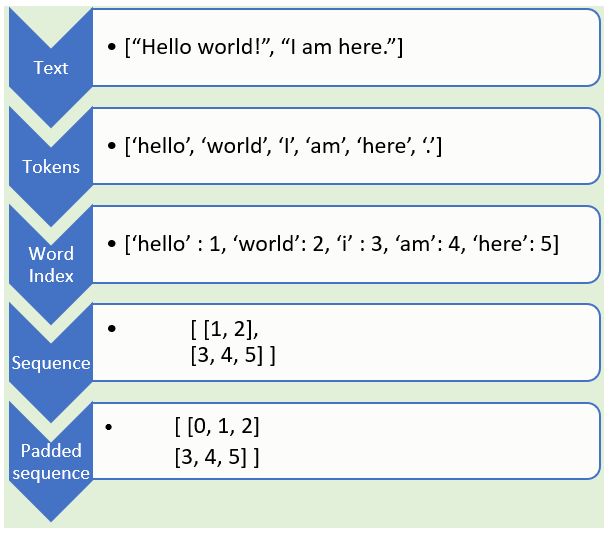

Image source: https://towardsdatascience.com/nlp-preparing-text-for-deep-learning-model-using-tensorflow2-461428138657

In [ ]:
tokenizer=Tokenizer(num_words = max_words)#, oov_tok = "<OOV>")
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
word_index = tokenizer.word_index
x_train = pad_sequences(train_sequences,maxlen = max_len,padding='post', truncating='post')


test_sequences = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(test_sequences,maxlen = max_len,padding='post', truncating='post')

y_train_numeric = np.zeros(len(y_train))
y_train_numeric[(y_train == "true")] = 1

y_test_numeric = np.zeros(len(y_test))
y_test_numeric[(y_test == "true")] = 1




## PREPROCESS THE EMBEDDINGS FROM GLOVE TWITTER

Use the function preprocess_embeddings to create an embedding matrix from the pre-trained Glove-Twitter embeddings.

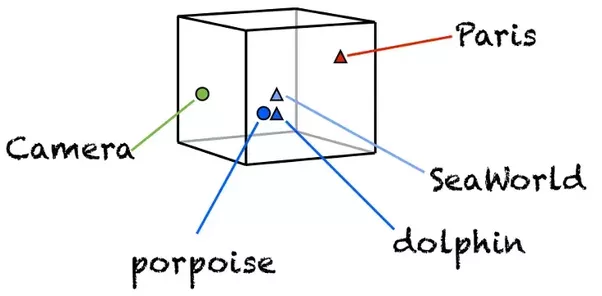

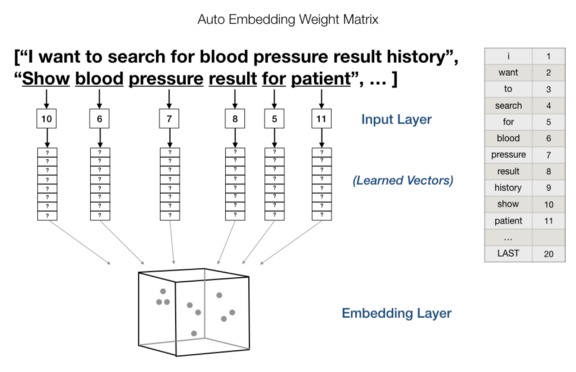

Image 1 source: https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge

Image 2 source: https://medium.com/@JMangia/coreml-with-glove-word-embedding-and-recursive-neural-network-part-2-ab238ca90970


In [ ]:
embeddings_matrix = preprocess_embeddings(pre_trained_embeddings_path, max_words, embedding_dim, word_index)

## BUILD A NEURAL NETWORK MODEL FOR LANGUAGE PROCESSING

The input parameters set by the user serve as arguments of a function which returns a Keras model object of a convolutional neural network.

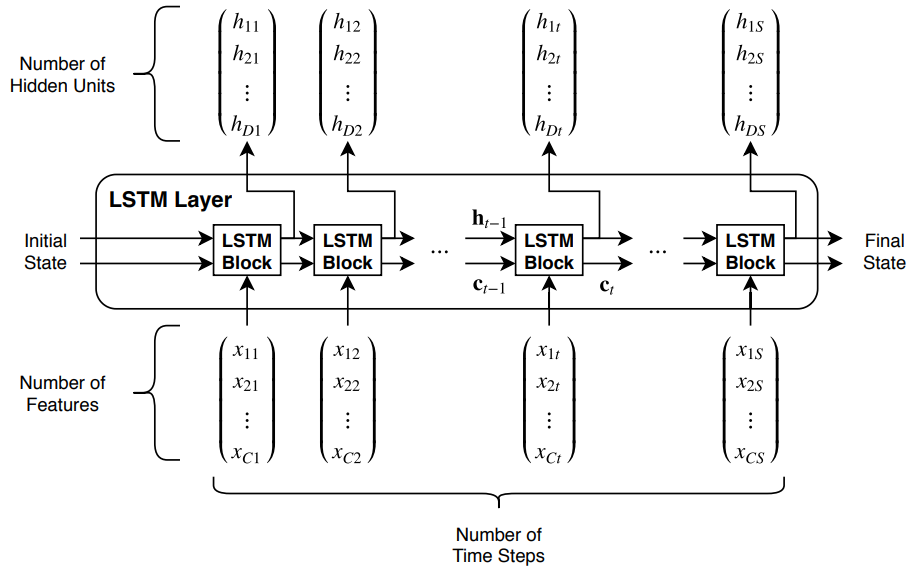

Image source: https://www.mathworks.com/help/deeplearning/ug/long-short-term-memory-networks.html

In [ ]:
model = build_model_nlp_lstm(regression_problem, 
                             max_words, 
                             embedding_dim, 
                             max_len, 
                             pre_trained_embeddings, 
                             embeddings_matrix, 
                             lstm_bidirectional,
                             lstm_layers_neurons, 
                             lstm_layers_recurrent_dropout, 
                             lstm_layers_dropout,
                             hidden_layers_neurons, 
                             hidden_activation_function, 
                             hidden_layers_L1_coeffs, 
                             hidden_layers_L2_coeffs, 
                             hidden_layers_dropout, 
                             final_layer_neurons, 
                             final_activation_function, 
                             model_optimizer, 
                             loss_function, 
                             metrics)

## COMPILE AND FIT THE MODEL

We first compile the model, i.e., set the optimizer, the loss function and the metrics.

Then, we define any eventual callback, e.g., "additional rules" that might lead to an early termination of the estimation or dynamical changes in the learning rate.

Finally, we fit the model to the data and estimate its set of parameters.

In [ ]:
model.compile(optimizer = model_optimizer, loss = loss_function, metrics = metrics)

early_exit = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

hst = model.fit(x_train, y_train_numeric, epochs = n_epochs, batch_size = batch_size, steps_per_epoch = x_train.shape[0]//batch_size, validation_data = (x_test, y_test_numeric), verbose = 1, callbacks =[early_exit])

## ANALYZE THE PERFORMANCE OF THE MODEL

We display two different metrics to assess the performances of the model

1. loss -> the value of the loss function in each epoch.
2. accuracy  -> "Calculates how often predictions equals labels.", see https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy

These metrics are recorded at the end of each training epoch and plotted in epoch vs. metric diagrams. Red lines represent the pattern of these metrics during training while blue lines represent the pattern of these metrics during the testing phase.

In [ ]:
analyze_performances(hst, n_epochs)

## CLASSIFY THE TEST IMAGES

We use our trained model to predict the labels of previously unseen text belonging to the test set.

In [ ]:
model_evaluation(model, x_test, y_test_numeric)